## Lion-Tiger classifier

**As suggested by prof. Howard this model classifies something other than dogs and cats, it classifies lions and tigers. I've hadpicked 14 images for training and 7 images for validation for each of the two labels**

In [63]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting! just a test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [64]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [65]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [66]:
PATH = "data2/"
sz=224

## First look at lion pictures

Our library will assume that you have *train* and *valid* directories. It also assumes that each dir will have subdirs for each class you wish to recognize (in this case, 'cats' and 'dogs').

In [70]:
os.listdir(PATH)

['.ipynb_checkpoints', 'valid', 'train']

In [72]:
os.listdir(f'{PATH}valid')

['lion', '.ipynb_checkpoints', 'tiger']

In [74]:
files = os.listdir(f'{PATH}valid/lion')[:5]
files

['lion-roar.jpg',
 'GiuyWTj.jpg',
 '16c4420ae3534ef4b0a7bb774e3d4687.jpg',
 '1280-588595868-african-lion-at-lake-in-serengeti.jpg',
 'Lion.jpg']

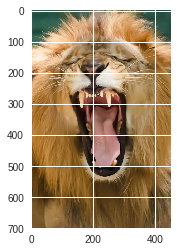

In [76]:
img = plt.imread(f'{PATH}valid/lion/{files[0]}')
plt.imshow(img);

Here is how the raw data looks like

In [77]:
img.shape

(700, 449, 3)

In [78]:
img[:2,:3]

array([[[51, 87, 75],
        [51, 87, 75],
        [52, 88, 76]],

       [[49, 87, 74],
        [49, 87, 74],
        [49, 87, 74]]], dtype=uint8)

## Our first model: quick start

We're going to use a <b>pre-trained</b> model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision. We'll be learning all about CNNs during this course.

We will be using the <b>resnet34</b> model. resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks). We'll be studying them in depth later, but for now we'll focus on using them effectively.

Here's how to train and evalulate a *dogs vs cats* model in 3 lines of code, and under 20 seconds:

In [15]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [91]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

epoch      trn_loss   val_loss   accuracy   
    0      0.805804   1.075054   0.533333  
    1      0.685441   0.657443   0.666667  
    2      0.605902   0.341052   0.933333  



[array([0.34105]), 0.9333333373069763]

**The model already has around 93% accuracy, but lets try and improve it using data augmentation, hyperparameter finder and many other things **

## Analyzing results: looking at pictures

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (i.e. those with highest probability that are correct)
4. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
5. The most uncertain labels (i.e. those with probability closest to 0.5).

In [80]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1])

In [82]:
# from here we know that 'lion' is label 0 and 'tigers' is label 1.
data.classes

['lion', 'tiger']

In [92]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(15, 2)

In [93]:
log_preds[:14]

array([[-0.27472, -1.42623],
       [-0.48235, -0.96058],
       [-0.29584, -1.3622 ],
       [-0.74888, -0.64036],
       [-0.50573, -0.92398],
       [-0.45813, -1.00094],
       [-0.65666, -0.73102],
       [-1.30255, -0.31723],
       [-1.54386, -0.24023],
       [-1.57647, -0.23156],
       [-1.90628, -0.16091],
       [-1.8733 , -0.16678],
       [-2.14094, -0.12505],
       [-1.30255, -0.31723]], dtype=float32)

In [96]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # probability

In [97]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [98]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [99]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


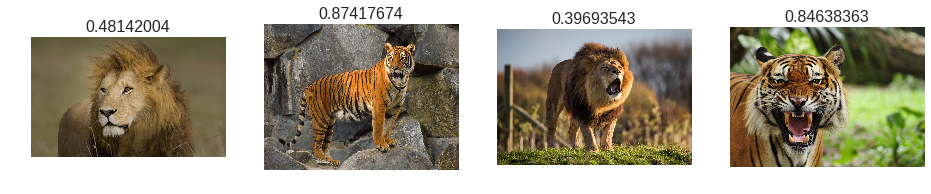

In [100]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [102]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct lions


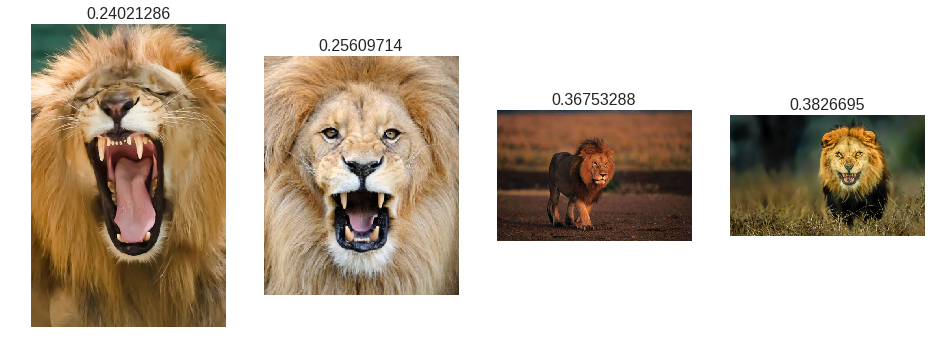

In [104]:
plot_val_with_title(most_by_correct(0, True), "Most correct lions")

Most incorrect lions


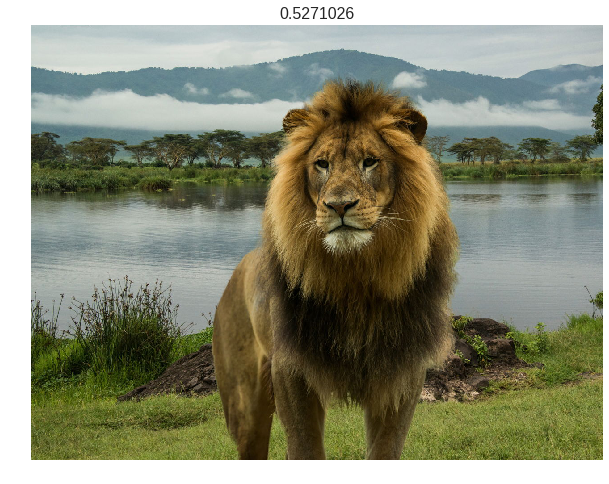

In [108]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect lions")

Most uncertain predictions


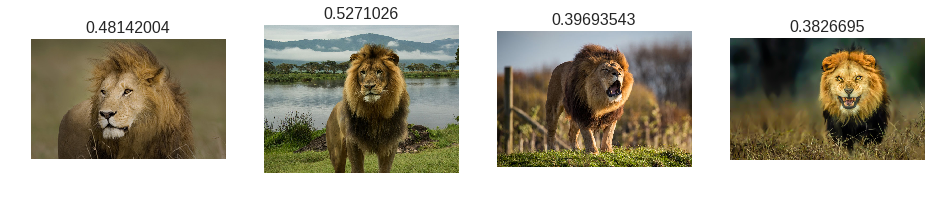

In [112]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Improving our model

### Data augmentation

If you try training for more epochs, you'll notice that we start to *overfit*, which means that our model is learning to recognize the specific images in the training set, rather than generalizing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through *data augmentation*. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

We can do this by passing `aug_tfms` (*augmentation transforms*) to `tfms_from_model`, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions `transforms_side_on`. We can also specify random zooming of images up to specified scale by adding the `max_zoom` parameter.

In [123]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [136]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [137]:
ims = np.stack([get_augs() for i in range(6)])

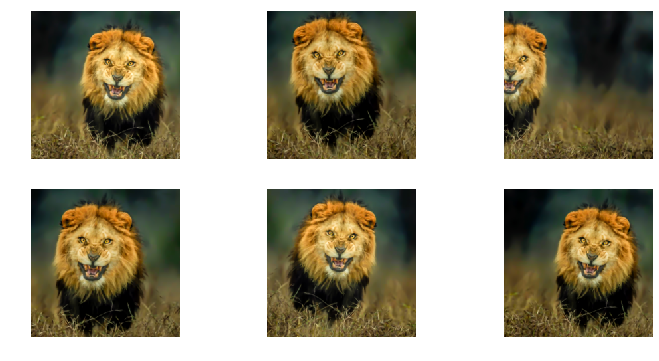

In [138]:
plots(ims, rows=2)

Let's create a new `data` object that includes this augmentation in the transforms.

In [139]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [149]:
learn.fit(0.01, 3)

epoch      trn_loss   val_loss   accuracy   
    0      0.012656   0.043801   1.0       
    1      0.023124   0.042033   1.0       
    2      0.022375   0.040035   1.0       



[array([0.04004]), 1.0]

## Boom Accuracy 100%

Our validation loss isn't improving much, so there's probably no point further training the last layer on its own.

Since we've got a pretty good model at this point, we might want to save it so we can load it again later without training it from scratch.

In [157]:
learn.save('lion-tiger')

In [158]:
learn.load('lion-tiger')

In [ ]:
## 